In [ ]:
dataset = 'test'

# Extrahera graf

In [ ]:
import pandas as pd
import numpy as np
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error

class DataPoint:
    def __init__(self, features, adjacency_matrix):
        self.features = features
        self.adjacency_matrix = adjacency_matrix
    

#Save all nodes
df_full = pd.read_csv(f"{dataset}.csv")
unique_sources = set(df_full['Source'].unique())
unique_destinations = set(df_full['Destination'].unique())
unique_values_union = unique_sources.union(unique_destinations)
nodes = list(unique_values_union)
#Split data in the shiet.


# print(nodes, len(nodes))

data = []
total_len = len(df_full)
nbr_of_intervalls = 100
interval_length = total_len/nbr_of_intervalls

for i in range(0,nbr_of_intervalls):
    print(f"{i}/{nbr_of_intervalls}")
    df_limited = df_full[int(i*interval_length):int( (i+1)*interval_length) ]


    features = []

    for node in nodes:
        nbr_source = 0
        nbr_dest = 0
        avg_len_src = 0
        avg_len_dest = 0
        
        # Check if the node is in the first 100 rows for source
        if node in df_limited['Source'].values:
            nbr_source = df_limited['Source'].value_counts()[node]

            filtered_df = df_limited[df_limited['Source'] == node]
            avg_len_src = filtered_df['Length'].mean()
        
        
        # Check if the node is in the first 100 rows for destination
        if node in df_limited['Destination'].values:
            nbr_dest = df_limited['Destination'].value_counts()[node]

            filtered_df = df_limited[df_limited['Destination'] == node]
            avg_len_dest = filtered_df['Length'].mean()
    
        features.append([nbr_source, nbr_dest, avg_len_src, avg_len_dest])

    # print(features)

    limited_sources = np.array(df_limited['Source'].unique())
    limited_destinations = np.array(df_limited['Destination'].unique())

    adjacency_matrix = np.zeros((len(nodes), len(nodes)))

    # Iterate through each row in the DataFrame and update the adjacency matrix
    for _, row in df_limited.iterrows():
        source_index = np.where(limited_sources == row['Source'])[0][0]
        destination_index = np.where(limited_destinations == row['Destination'])[0][0]
        adjacency_matrix[source_index, destination_index] = 1

    data_point = DataPoint(features, adjacency_matrix)
    data.append(data_point)


with open(f"{dataset}.pkl", "wb") as f:
    pickle.dump(data, f)

# Train

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from custom_gcn import GCN, DataPoint

def load_data(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

training_data = load_data(f"{dataset}.pkl")


test_data_point = DataPoint(training_data[56].features, training_data[56].adjacency_matrix)



# Initialize a GCN model
input_dim = 4
hidden_dim = 32  # You can tune this
hidden_dim2 = 16
output_dim = 12  # You can tune this, should match autoencoder input

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN(input_dim, hidden_dim, hidden_dim2, output_dim).to(device)
gcn_model.eval()  # Set the model to evaluation mode

def extract_features(data, train = True):
    adj_matrix = torch.tensor(data[0].adjacency_matrix, dtype=torch.float).to(device)    

    gcn_transformed_features = []
    for i, data_point in enumerate(data):
       
        features_tensor = torch.tensor(data_point.features, dtype=torch.float).to(device)
        adj_matrix = torch.tensor(data_point.adjacency_matrix, dtype=torch.float).to(device)
        
        transformed_features = gcn_model(features_tensor, adj_matrix).detach().cpu().numpy()
        gcn_transformed_features.append(transformed_features.flatten())
   
    gcn_transformed_features = np.array(gcn_transformed_features)
    return gcn_transformed_features

gcn_transformed_features = extract_features(training_data)


# Now we proceed with the autoencoder using the transformed features
input_dim = gcn_transformed_features.shape[1]
encoding_dim = output_dim  # This should match the GCN's output_dim

input_img = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
encoded = layers.Dropout(0.2)(encoded)  # Adding dropout with 20% rate
encoded = layers.Dense(int(encoding_dim * 3/4), activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)  # Adding dropout
encoded = layers.Dense(int(encoding_dim / 2), activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)  # Adding dropout

decoded = layers.Dense(int(encoding_dim * 3/4), activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)  # Adding dropout
decoded = layers.Dense(encoding_dim, activation='relu')(decoded)
decoded = layers.Dropout(0.2)(decoded)  # Adding dropout
decoded = layers.Dense(input_dim, activation='tanh')(decoded)




def normalize_to_minus_one_and_one(data, train=True):
    min_vals = np.min(gcn_transformed_features, axis=0)
    max_vals = np.max(gcn_transformed_features, axis=0)
    ranges = max_vals - min_vals
    ranges[ranges==0] = 0.00001
    
    normalized_data = (data - min_vals) / ranges  # Scale to [0, 1]
    normalized_data = normalized_data * 2 - 1  # Scale to [-1, 1]
    
    return normalized_data

# Standardize the training data
gcn_transformed_features_scaled = normalize_to_minus_one_and_one(gcn_transformed_features)#(gcn_transformed_features - mean) / std_dev
train_data, val_data = train_test_split(gcn_transformed_features_scaled, test_size=0.2)

train_new_autoencoder = True
if train_new_autoencoder:
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Train the autoencoder
    history = autoencoder.fit(train_data, train_data,
                            epochs=200,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(val_data, val_data)
                            )
    with open('autoencoder_history.pkl', 'wb') as file:
        pickle.dump(history, file)
    autoencoder.save('autoencoder_model')
else:
    autoencoder = tf.keras.models.load_model('autoencoder_model')
    with open('autoencoder_history.pkl', 'rb') as file:
        history = pickle.load(file)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.6375 - val_loss: 0.6566
Epoch 2/200
1/1 [==============================] - 0s 38ms/step - loss: 0.6324 - val_loss: 0.6547
Epoch 3/200
1/1 [==============================] - 0s 34ms/step - loss: 0.6297 - val_loss: 0.6526
Epoch 4/200
1/1 [==============================] - 0s 31ms/step - loss: 0.6272 - val_loss: 0.6491
Epoch 5/200
1/1 [==============================] - 0s 32ms/step - loss: 0.6241 - val_loss: 0.6444
Epoch 6/200
1/1 [==============================] - 0s 29ms/step - loss: 0.6182 - val_loss: 0.6386
Epoch 7/200
1/1 [==============================] - 0s 29ms/step - loss: 0.6151 - val_loss: 0.6321
Epoch 8/200
1/1 [==============================] - 0s 30ms/step - loss: 0.6087 - val_loss: 0.6253
Epoch 9/200
1/1 [==============================] - 0s 30ms/step - loss: 0.6053 - val_loss: 0.6176
Epoch 10/200
1/1 [==============================] - 0s 29ms/step - loss: 0.5955 - val_loss: 0.6090
Epoch 11/200
1/1 [===

Epoch 84/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0984 - val_loss: 0.0988
Epoch 85/200
1/1 [==============================] - 0s 29ms/step - loss: 0.1135 - val_loss: 0.0985
Epoch 86/200
1/1 [==============================] - 0s 31ms/step - loss: 0.1058 - val_loss: 0.0983
Epoch 87/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1080 - val_loss: 0.0980
Epoch 88/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0919 - val_loss: 0.0977
Epoch 89/200
1/1 [==============================] - 0s 29ms/step - loss: 0.1212 - val_loss: 0.0973
Epoch 90/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0974 - val_loss: 0.0970
Epoch 91/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0809 - val_loss: 0.0966
Epoch 92/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1017 - val_loss: 0.0962
Epoch 93/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1108 - val_loss: 0.0959
Epoch 94/2

1/1 [==============================] - 0s 28ms/step - loss: 0.0663 - val_loss: 0.0980
Epoch 167/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0662 - val_loss: 0.0980
Epoch 168/200
1/1 [==============================] - 0s 27ms/step - loss: 0.0667 - val_loss: 0.0980
Epoch 169/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0658 - val_loss: 0.0979
Epoch 170/200
1/1 [==============================] - 0s 27ms/step - loss: 0.0725 - val_loss: 0.0978
Epoch 171/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0694 - val_loss: 0.0977
Epoch 172/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0695 - val_loss: 0.0975
Epoch 173/200
1/1 [==============================] - 0s 27ms/step - loss: 0.0644 - val_loss: 0.0973
Epoch 174/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0692 - val_loss: 0.0972
Epoch 175/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0638 - val_loss: 0.0971
Epoch 176/200


INFO:tensorflow:Assets written to: autoencoder_model/assets


# Test

Training Loss:  0.0708337277173996
Validation Loss:  0.09722314029932022


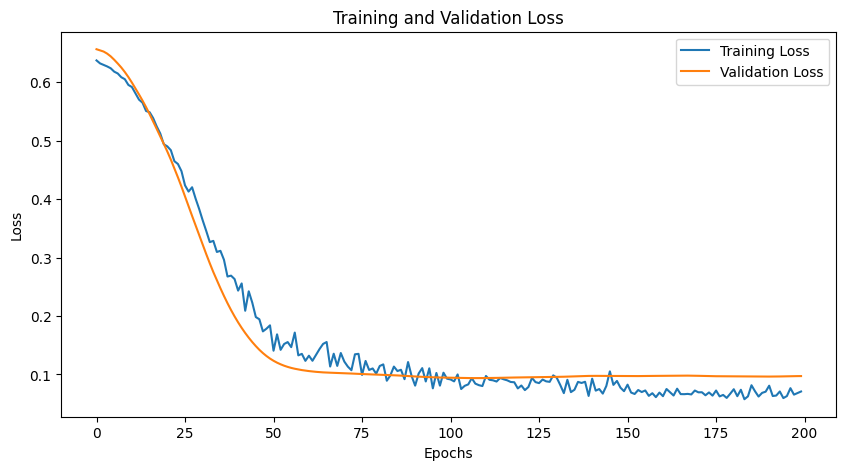

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from custom_gcn import GCN, DataPoint

# Initialize GCN model
input_dim = 4
hidden_dim = 32
hidden_dim2 = 16
output_dim = 12  # should match autoencoder input

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN(input_dim, hidden_dim, hidden_dim2, output_dim).to(device)
gcn_model.eval()

def extract_features(data, train = True):
    adj_matrix = torch.tensor(data[0].adjacency_matrix, dtype=torch.float).to(device)    

    gcn_transformed_features = []
    for i, data_point in enumerate(data):
    
        features_tensor = torch.tensor(data_point.features, dtype=torch.float).to(device)
        adj_matrix = torch.tensor(data_point.adjacency_matrix, dtype=torch.float).to(device)
        
        transformed_features = gcn_model(features_tensor, adj_matrix).detach().cpu().numpy()
        gcn_transformed_features.append(transformed_features.flatten())

    gcn_transformed_features = np.array(gcn_transformed_features)
    return gcn_transformed_features

def normalize_to_minus_one_and_one(data, train=True):
    min_vals = np.min(gcn_transformed_features, axis=0)
    max_vals = np.max(gcn_transformed_features, axis=0)
    ranges = max_vals - min_vals
    ranges[ranges==0] = 0.00001
    
    normalized_data = (data - min_vals) / ranges  # Scale to [0, 1]
    normalized_data = normalized_data * 2 - 1  # Scale to [-1, 1]
    
    return normalized_data

def load_data(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

training_data = load_data(f"{dataset}.pkl")
test_data_point = DataPoint(training_data[56].features, training_data[56].adjacency_matrix)
gcn_transformed_features = extract_features(training_data)

# Standardize training data
gcn_transformed_features_scaled = normalize_to_minus_one_and_one(gcn_transformed_features)
train_data, val_data = train_test_split(gcn_transformed_features_scaled, test_size=0.2)

autoencoder = tf.keras.models.load_model('autoencoder_model')
with open('autoencoder_history.pkl', 'rb') as file:
    history = pickle.load(file)


reconstructed_data = autoencoder.predict(val_data, verbose=None)

num_samples_to_display = 2
indices = np.random.choice(range(len(val_data)), num_samples_to_display)

# print("Comparing original and reconstructed values for random data points:")
# for i, index in enumerate(indices):
#     print(f"\nData Point {i + 1} (Index {index}):")
    
#     print(list(zip(val_data[index][:10], reconstructed_data[index][:10])))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training Loss: ", train_loss[-1])
print("Validation Loss: ", val_loss[-1])

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot errors

Text(0.5, 1.0, 'result_mae')

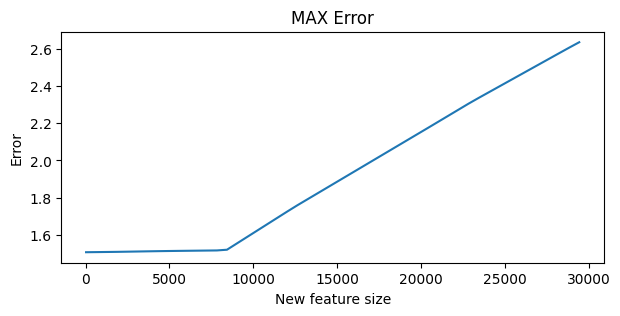

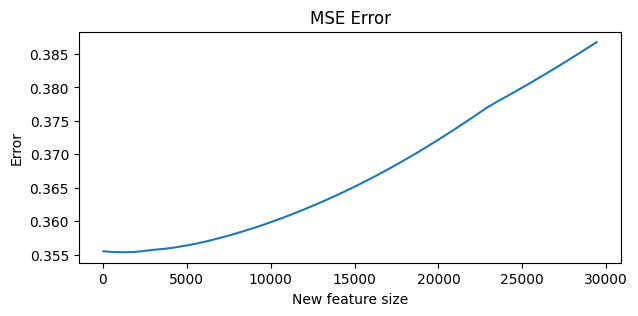

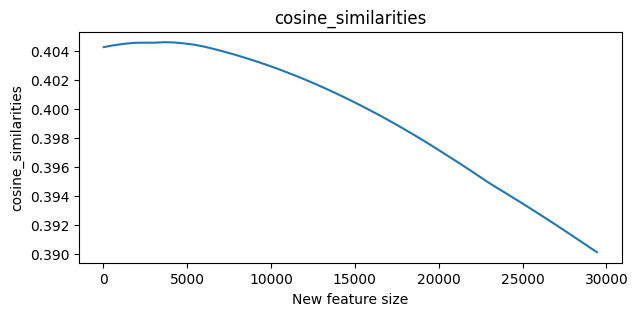

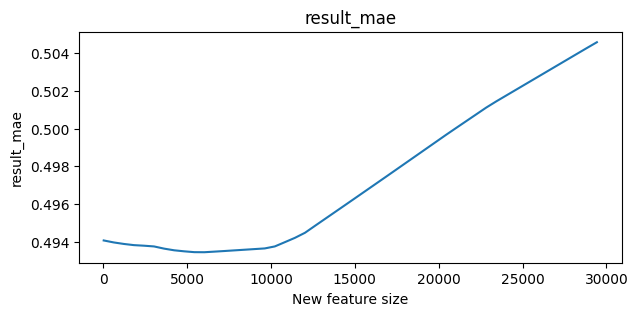

In [23]:
from sklearn.metrics import mean_absolute_error
result_max = []
result_mse = []
result_cosine = []
result_mae = []
for i in range(1,1000,20):
    test_data_point.features[10][3] = 30*i
    test_data_point.features[4][2] = 30*i
    test_data_point.features[20][3] = 30*i
#     print(i)
    test_data_gcn_features = extract_features([test_data_point], False)
    test_data_gcn_features_scaled = normalize_to_minus_one_and_one(test_data_gcn_features, False)
    test_data_prediction = autoencoder.predict(test_data_gcn_features_scaled, verbose=None)
    max_error = np.max(test_data_gcn_features_scaled - test_data_prediction)
    mse_error = mean_squared_error(test_data_gcn_features_scaled, test_data_prediction)
    cosine_similarities = pairwise.cosine_similarity(test_data_gcn_features_scaled, test_data_prediction)
    mae_error = mean_absolute_error(test_data_gcn_features_scaled, test_data_prediction)

    result_max.append(max_error)
    result_mse.append(mse_error)
    result_cosine.append(cosine_similarities[0][0])
    result_mae.append(mae_error)

# print(result_max[:5])
# print("______________________________________________________________________")
# print(result_mse[:5])

x = range(30,30000,600)

plt.figure(figsize=(7, 3))
plt.plot(x, result_max)
plt.xlabel('New feature size')
plt.ylabel('Error')
plt.title('MAX Error')

plt.figure(figsize=(7, 3))
plt.plot(x, result_mse)
plt.xlabel('New feature size')
plt.ylabel('Error')
plt.title('MSE Error')

plt.figure(figsize=(7, 3))
plt.plot(x, result_cosine)
plt.xlabel('New feature size')
plt.ylabel('cosine_similarities')
plt.title('cosine_similarities')
plt.figure(figsize=(7, 3))

plt.plot(x, result_mae)
plt.xlabel('New feature size')
plt.ylabel('result_mae')
plt.title('result_mae')